# Research paper clustering challenge

## Data preprocessing

Defined, and imported some necessary libraries

In [44]:
from pypdf import PdfReader
from pdfminer.high_level import extract_text
import spacy
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

paper_paths = glob.glob(os.path.join('dataset', '*'))
print(len(paper_paths))

79


So, after some testing on the three libs: PyPDF, PyMuPDF and PDFMiner, I decided that PDFMiner suits best for the purpose

In [31]:
def extract_abstract(path):
    text = extract_text(path).lower().split('\n')   # Extract content using PDFMiner
    abstract_content = ""
    tokens = []

    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # Disable unnecessary components for faster processing

    for line in text:
        if len(line) == 0:
            tokens = nlp(abstract_content)
            
            if len(tokens) > 100 and len(tokens) < 500:
                break
            else:
                abstract_content = ""
        else:
            abstract_content += line + " "

    lemmas = [token.lemma_ for token in tokens if not token.is_stop]
    return lemmas

papers_tokens = []
for path in paper_paths:
    papers_tokens.append(extract_abstract(path))

## Text Vectorization

Firstly, let's try the TF-IDF (term frequency - inverse document frequency) vector

In [32]:
abstracts_as_texts = [' '.join(tokens) for tokens in papers_tokens]

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit-transform the corpus (abstracts_as_texts) to TF-IDF vectors
tfidf_vectors = vectorizer.fit_transform(abstracts_as_texts)

# Get feature names (words/tokens)
feature_names = vectorizer.get_feature_names_out()

# Print TF-IDF vectors and feature names
print(tfidf_vectors.toarray().shape)  # Print TF-IDF vectors as dense array
print(tfidf_vectors.toarray())
print(feature_names.shape)  # Let's see how many tokens there is
# print(feature_names)

(79, 2698)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.08937034 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(2698,)


Trying a word embedding model. Spefically, I'm using Word2Vec model

## Clustering

Let's try K-means clustering first !! I'm starting off with Elbow method, using the number of clusters from 1 to only 10, as we don't have that many research papers. Calculating Within-Cluster Sum of Squares (WCSS) on each k, then draw out the result

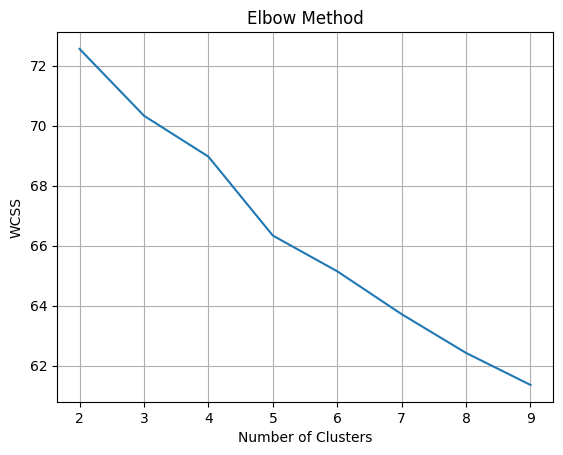

In [63]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_vectors)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(2, 10))
plt.grid(True)
plt.show()

Great !! So, there is a huge reduction at the point where k = 5, so I believe that this is the elbow point. But to make sure if there's any other elbow point, I will draw from 1 to n (n is the amount of observations/research papers)

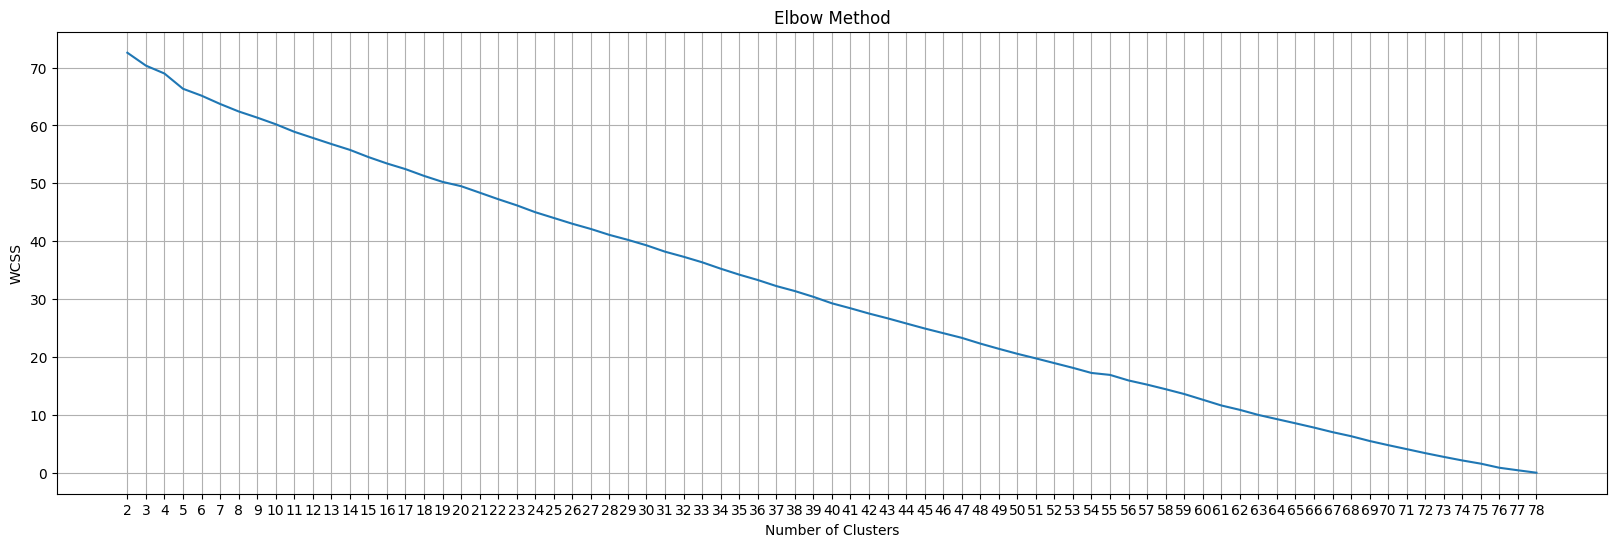

In [62]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(2, len(paper_paths)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 6))
plt.plot(range(2, len(paper_paths)), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(2, len(paper_paths)))
plt.grid(True)
plt.show()

It still go down, but not that much. So, I believe k = 5 is the only elbow point. But now, let's try other metrics too. Starting with silhouette analysis

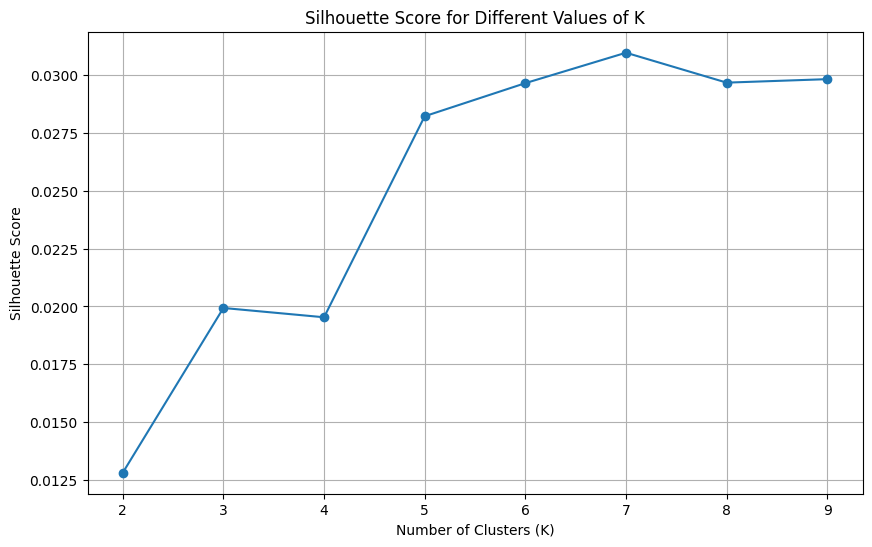

In [48]:
# Range of clusters to evaluate (use the best K from Elbow Method)
k_values = range(2, 10)

# Initialize lists to store silhouette scores
silhouette_scores = []

# Compute silhouette scores for each K
for k in k_values:
    # Initialize KMeans with K clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_vectors)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()


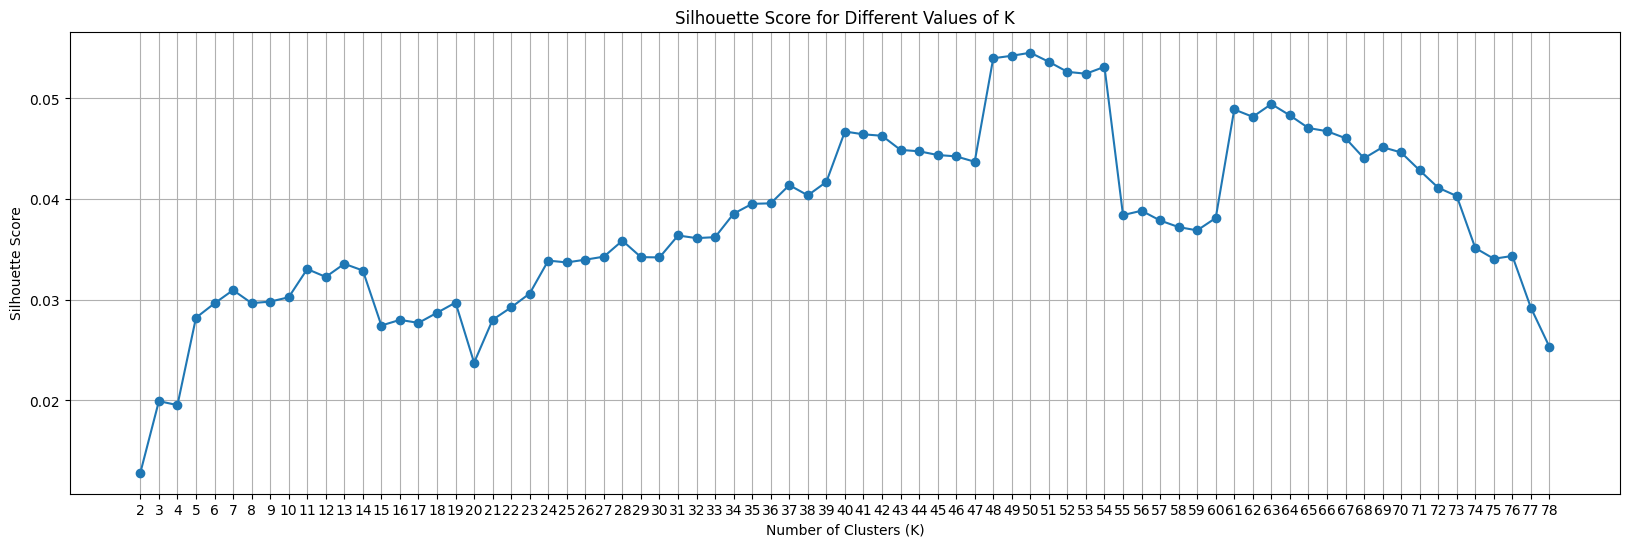

In [58]:
# Range of clusters to evaluate (use the best K from Elbow Method)
k_values = range(2, 79)

# Initialize lists to store silhouette scores
silhouette_scores = []

# Compute silhouette scores for each K
for k in k_values:
    # Initialize KMeans with K clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_vectors)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(20, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()


Wow !! So, the peak of the silhouette score is in k=50, which is extremely different from k=5 that we found using Elbow method. Maybe I should try the last one, Davies-Bouldin index, and see what we can get

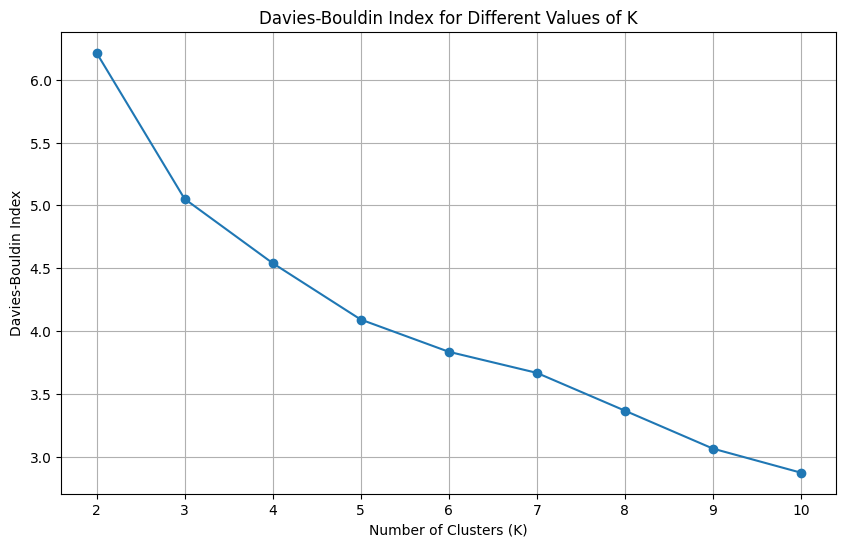

In [64]:
k_values = range(2, 11)

# Initialize list to store Davies-Bouldin index scores
db_scores = []

# Compute Davies-Bouldin index for each K
for k in k_values:
    # Initialize KMeans with K clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_vectors)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(tfidf_vectors.toarray(), cluster_labels)
    db_scores.append(db_index)

# Plot Davies-Bouldin index scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid(True)
plt.show()

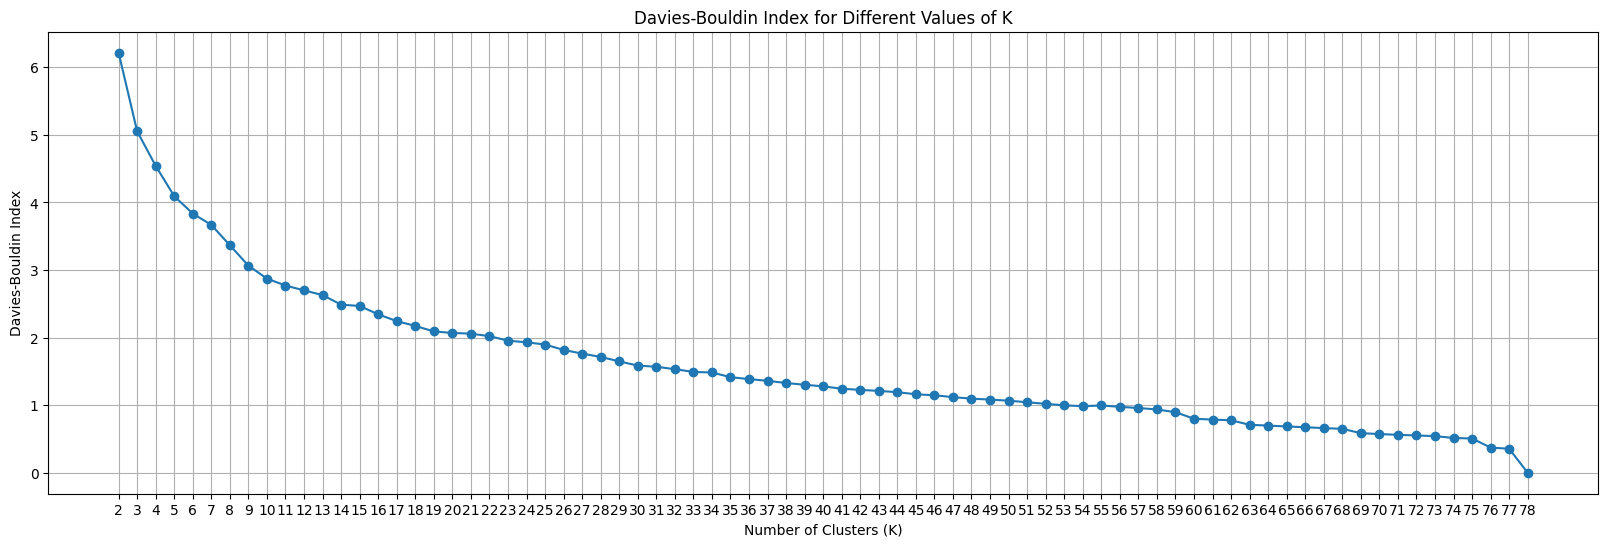

In [67]:
k_values = range(2, len(paper_paths))

# Initialize list to store Davies-Bouldin index scores
db_scores = []

# Compute Davies-Bouldin index for each K
for k in k_values:
    # Initialize KMeans with K clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_vectors)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(tfidf_vectors.toarray(), cluster_labels)
    db_scores.append(db_index)

# Plot Davies-Bouldin index scores
plt.figure(figsize=(20, 6))
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [70]:
optimal_k = 10  # Replace with your optimal K value

# Initialize KMeans with optimal K clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit KMeans clustering model to tfidf_vectors
cluster_labels = kmeans.fit_predict(tfidf_vectors)

# Print cluster labels for each document (optional)
for i, label in enumerate(cluster_labels):
    print(f"Document {paper_paths[i]}: Cluster {label}")

Document dataset/Model_Predictive_Current_Control_of_Nine-Phase_Open-End_Winding_PMSMs_With_an_Online_Virtual_Vector_Synthesis_Strategy.pdf: Cluster 2
Document dataset/science.ade1499.pdf: Cluster 2
Document dataset/huang-et-al-2022-bacterial-growth-induced-tobramycin-smart-release-self-healing-hydrogel-for-pseudomonas-aeruginosa.pdf: Cluster 8
Document dataset/Voltage_Sensorless_Based_Model_Predictive_Control_With_Battery_Management_System_For_Solar_PV_Powered_On-Board_EV_Charging.pdf: Cluster 4
Document dataset/sustainability-15-01418-v2.pdf: Cluster 4
Document dataset/1-s2.0-S136403212200199X-main.pdf: Cluster 4
Document dataset/1-s2.0-S0306261917306207-main.pdf: Cluster 0
Document dataset/energies-16-00280.pdf: Cluster 1
Document dataset/Small - 2019 - Pu - Recent Progress in Rechargeable Sodium‐Ion Batteries  toward High‐Power Applications.pdf: Cluster 5
Document dataset/Maraschky_2023_J._Electrochem._Soc._170_066504.pdf: Cluster 5
Document dataset/1-s2.0-S0960148116302865-main.pd